In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow_datasets as tfds

#tfds.list_builders()

In [3]:
train_data, info = tfds.load("cifar10", split="train[10%:]", with_info = True)
valid_data = tfds.load("cifar10", split="train[:10%]")
test_data = tfds.load("cifar10", split="test")

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteB69GKB/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteB69GKB/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


In [13]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.0,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [4]:
def parse_aug_fn(dataset):
    def zoom(x, sh = 299, sw = 299):
        x = tf.image.resize(x, (sh, sw))
        return x
    
    # 影像標準化
    x = tf.cast(dataset['image'], tf.float32) / 255.
    # 影像放大到224*224
    x = zoom(x)
    y = tf.one_hot(dataset['label'], 10)
    y = y
    
    return x, y

In [5]:
#模型儲存目錄
model_dir = '/content/drive/My Drive/Colab Notebooks/cifar10/models'
if os.path.isdir(model_dir):
    print("已存在路徑「{}」".format(model_dir))
else:
    print("已建立路徑「{}」".format(model_dir))
    os.makedirs(model_dir)

已存在路徑「/content/drive/My Drive/Colab Notebooks/cifar10/models」


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 128
train_num = int(info.splits['train'].num_examples / 10) * 9
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data = train_data.batch(batch_size)
  
valid_data = valid_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.batch(batch_size)
 
test_data = test_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.batch(batch_size)

In [16]:
#回調函數
log_dir = os.path.join('content','drive','My Drive','Colab Notebooks','cifar10','InceptionV3-L2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + "/Best-model-InceptionV3-L2.h5", monitor='val_categorical_accuracy', mode='max')
# model_esp = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=300, mode='max')

In [23]:
input_shape = (299, 299)
base_model = tf.keras.applications.InceptionV3(include_top = False, weights="imagenet", pooling='avg', input_shape=input_shape+(3,))
model=tf.keras.Sequential([
    base_model,
    layers.Dense(1024,activation='relu', kernel_regularizer = 'l2'),
    layers.Dense(10,activation='softmax')
])
 
for layer in model.layers:
    layer.trainable = False
# 或者使用如下方法凍結所有層
# model.trainable = False 
model.layers[-1].trainable = True
model.layers[-2].trainable = True

print("顯示可以訓練的所有層")
for x in model.trainable_weights:
    print(x.name)

print("顯示不可訓練的所有層")
for x in model.non_trainable_weights:
    print(x.name)
 


顯示可以訓練的所有層
dense_2/kernel:0
dense_2/bias:0
dense_3/kernel:0
dense_3/bias:0
顯示不可訓練的所有層
conv2d_94/kernel:0
batch_normalization_94/beta:0
batch_normalization_94/moving_mean:0
batch_normalization_94/moving_variance:0
conv2d_95/kernel:0
batch_normalization_95/beta:0
batch_normalization_95/moving_mean:0
batch_normalization_95/moving_variance:0
conv2d_96/kernel:0
batch_normalization_96/beta:0
batch_normalization_96/moving_mean:0
batch_normalization_96/moving_variance:0
conv2d_97/kernel:0
batch_normalization_97/beta:0
batch_normalization_97/moving_mean:0
batch_normalization_97/moving_variance:0
conv2d_98/kernel:0
batch_normalization_98/beta:0
batch_normalization_98/moving_mean:0
batch_normalization_98/moving_variance:0
conv2d_102/kernel:0
batch_normalization_102/beta:0
batch_normalization_102/moving_mean:0
batch_normalization_102/moving_variance:0
conv2d_100/kernel:0
conv2d_103/kernel:0
batch_normalization_100/beta:0
batch_normalization_100/moving_mean:0
batch_normalization_100/moving_variance

In [25]:
#優化器、損失函數，指標函數
model.compile(keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 23,911,210
Trainable params: 2,108,426
Non-trainable params: 21,802,784
_________________________________________________________________


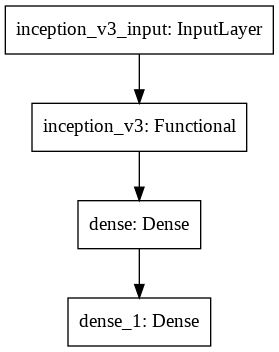

In [21]:
plot_model(model)

In [26]:
# 訓練前的評估
print("train_data:")
model.evaluate(train_data)
print("valid_data:")
model.evaluate(valid_data)
print("test_data:")
model.evaluate(test_data)

train_data:
352/352 [==============================] - 504s 1s/step - loss: 16.1486 - categorical_accuracy: 0.0867
valid_data:
40/40 [==============================] - 56s 1s/step - loss: 16.1477 - categorical_accuracy: 0.0926
test_data:
79/79 [==============================] - 113s 1s/step - loss: 16.1466 - categorical_accuracy: 0.0891


[16.146570205688477, 0.08910000324249268]

In [7]:
# 讀取模型(有事先訓練過了，會讀取這個模型是要避免重新訓練，浪費時間)
model = tf.keras.models.load_model(model_dir + "/Best-model-InceptionV3-L2.h5")

In [ ]:
# 有EarlyStopping
# history = model.fit(train_data, epochs=1000, validation_data = valid_data, callbacks=[model_cbk, model_mckp, model_esp])
history = model.fit(train_data, epochs=1000, validation_data = valid_data, callbacks=[model_cbk, model_mckp])

Epoch 1/1000
      1/Unknown - 0s 617us/step - loss: 0.3971 - categorical_accuracy: 0.8984WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


    274/Unknown - 387s 1s/step - loss: 0.4778 - categorical_accuracy: 0.8603

In [8]:
# 訓練後的評估
print("train_data:")
model.evaluate(train_data)
print("valid_data:")
model.evaluate(valid_data)
print("test_data:")
model.evaluate(test_data)

train_data:
352/352 [==============================] - 390s 1s/step - loss: 0.4403 - categorical_accuracy: 0.8744
valid_data:
40/40 [==============================] - 44s 1s/step - loss: 0.5309 - categorical_accuracy: 0.8482
test_data:
79/79 [==============================] - 88s 1s/step - loss: 0.5511 - categorical_accuracy: 0.8439


[0.5510784983634949, 0.8439000248908997]